# Assessing the first baroclinic Rossby radius of deformation
__Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute__

#### The project - Havvind

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 6 (?) different farms along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 1x1500MW (430 km²) + 2x2100MW (600km² + 600 km²)
* 258 turbines

### Calculation of mean internal Rossby radius

To investigate the impact of wind farms at sea it is useful to make the study area smaller, i.e. not use the whole model domain. The Rossby radius or deformation radius allows us to delimit the area safely while making sure that the relevant baroclinic dynamics are still within the domain. By taking 1-2 deformation radii as our domain of investigation around the wind farm, we're making sure that the internal dynamics are dominated by internal baroclinic instabilities, and that changes seen are due to interference of wind mills and not other large scale effects. The radius is telling about the length of deformation of a wave, that is a length scale where the rotation of Earth affects the currents and geostrophy dominates.

Sperrevik et al. (2017) calculated the internal Rossby radii using the following method.

$$R_1 = \frac{c_1}{\mid f \mid}$$
where $f$ is the local Coriolis parameter and $c_1$ the phase speed of a first mode baroclinic gravity wave. The phase speed can be solved as an eigenvalue problem, but we will deploy the method of Chelton et al. (1998) and use the WKB-approximation.
$$R_1 \approx R_1^{WKB} = \frac{1}{\mid f \mid \pi}\int_{-H}^{0}N(z) dz$$

Here, $H$ is the local water depth and $N$ the buoyancy frequency. Sperrevik et al. (2017) calculated the radius for an area in Northern Norway, Lofoten, as shown in the figure below.

<p align="center">
  <img src="Sperrevik_etal_2017_fig5.png" alt="Sperrevik et al. (2017)">
</p>

Here we have the internal deformation radius for the spring months of 1984. The radii has its minimum after the winter and increases towards the summer due to a stronger stratification developing. I will use this figure as a reference to see if the values I compute are reasonable.

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import cartopy 
from datetime import datetime, timedelta
import pandas as pd
from get_turbine_coords import get_turbine_coords
from netCDF4 import Dataset
from roppy import SGrid


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [2]:
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [6]:
path = '/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF_02_norkyst_avg_0001_brr.nc'

In [7]:
ds = xr.open_dataset(path)

In [8]:
def get_timestamp(ds):
    ref = datetime(1970, 1, 1)
    ds_seconds_since_ref = ds.ocean_time.values
    timestamp = pd.to_datetime(ref + timedelta(seconds=ds_seconds_since_ref[0]))
    return timestamp

In [9]:
time = get_timestamp(ds)

In [13]:
ds.gamma_r

<xarray.DataArray 'gamma_r' (ocean_time: 1, eta_rho: 1148, xi_rho: 2747)>
[3153556 values with dtype=float64]
Coordinates:
  * ocean_time  (ocean_time) float64 1.644e+09
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  Baroclinic Rossby radius
    units:      meter

In [22]:
lon = grid.lon_rho
lat = grid.lat_rho

Text(0.5, 0.98, '2022-02-02 12:00:00')

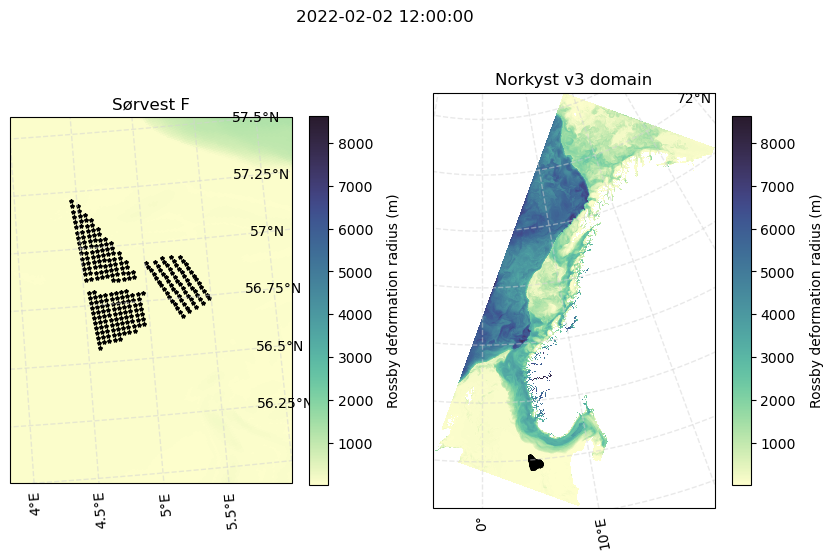

In [30]:
proj = ccrs.NorthPolarStereo()

fig, ax = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': proj})
cmap='cmo.deep'

# Zoomed in plot
ax[0].set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
area_plot = ax[0].pcolormesh(lon, lat, ds.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)
cbar = plt.colorbar(area_plot, ax=ax[0], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius (m)', labelpad=10)
cbar.ax.tick_params(labelsize=10)

ax[0].set_title('Sørvest F')

# Whole domain plot
domain_plot = ax[1].pcolormesh(lon, lat, ds.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)
cbar = plt.colorbar(domain_plot, ax=ax[1], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius (m)', labelpad=10)
cbar.ax.tick_params(labelsize=10)

ax[1].set_title('Norkyst v3 domain')


for axs in ax.flatten():
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=3) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

fig.suptitle(time)

In [42]:
ds.gamma_r

<xarray.DataArray 'gamma_r' (ocean_time: 1, eta_rho: 1148, xi_rho: 2747)>
[3153556 values with dtype=float64]
Coordinates:
  * ocean_time  (ocean_time) float64 1.644e+09
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  Baroclinic Rossby radius
    units:      meter

__Onsdag__
- Finn ut hvordan du bruker grid sammen med filene dine.
- Vil: hente ut indeks av eta og xi (y,x) for å plukke ut et punkt gitt fra NVE presentasjonen
- Prøv å åpne flere filer og plot time series
- Se om du klarer å finne månedlig mean -> eks funksjon som leser inn alle filer med 'ref-02' og så tar gj.snitt og spytter ut

Vil ha:
- kart over månedlig mean
- tidsserie i punkt av månedlig mean evt rolling mean?? idk hva gir fysisk mening
- prøve å ta horisontalt gj snitt av området og plotte tidsserie

Når det er gjort: ta median elns av verdiene og bruk det til å avgrense rundt. dvs hent ut indekser som trengs!

Videre:
start med å regne ut på dagsfil med/uten turbin. når metoden sitter -> lag program som kjører alle filene eller på time mean av filene.